## Bibliotecas

In [193]:
import pandas as pd
import numpy as np

# MCA
from scipy.stats import chi2_contingency
import prince

# Gráficos
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Clusterização
import sklearn as sk 
from sklearn.cluster import KMeans 

import os # Esta biblioteca foi importada para corrigir um warning ao usar a função KMeans()
os.environ["OMP_NUM_THREADS"] = '1'

## Base de Dados

Os dados são públicos e foram cedidos por um banco português em 2012 de uma pesquisa de marketing realizada no período, há mais de 45 mil observações o que é muito desejável neste tipo de análise pois quanto mais observações mais confiável é o resultado encontrado. Infelizmente gostaria que tivesse mais informações como renda e sexo, entretanto tem o suficiente para rodarmos o modelo e obter resultados interessantes.

https://archive.ics.uci.edu/dataset/222/bank+marketing

In [5]:
data_original = pd.read_csv(r"C:\Users\emanu\OneDrive\Área de Trabalho\bank-full.csv", sep=';')
data_original

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Abaixo nós transformamos as variáveis 'balance' que calcula o balanço médio anual dos clientes e o 'age' que se refere a idade em variáveis categóricas, criando faixas de idade e faixas de balanços. Optou-se por separar em quintis originando 5 faixas distintas. 

In [6]:
np.percentile(data_original['balance'], [25,50,75])

array([  72.,  448., 1428.])

In [7]:
age_bins = [18, 25, 45, 64, 100]
age_labels = ['young adult', 'adult', 'middle age', 'senior']

balance_bins = [-9000, 0, 110000]
balance_labels = ['Debtor', 'Creditor']

data_original['age_adj'] = pd.cut(data_original['age'], bins=age_bins, labels=age_labels, right=False)
data_original['balance_adj'] = pd.cut(data_original['balance'], bins=balance_bins, labels=balance_labels, right=False)

### Base de Dados Filtrado

In [8]:
data = data_original[['job','age_adj','balance_adj','education']]
data = data[data != 'unknown'].dropna()
data

,job,age_adj,balance_adj,education
0,management,middle age,Creditor,tertiary
1,technician,adult,Creditor,secondary
2,entrepreneur,adult,Creditor,secondary
5,management,adult,Creditor,tertiary
6,management,adult,Creditor,tertiary
...,...,...,...,...
45206,technician,middle age,Creditor,tertiary
45207,retired,senior,Creditor,primary
45208,retired,senior,Creditor,secondary
45209,blue-collar,middle age,Creditor,secondary


In [9]:
for i in data.columns:
    print(data[i].value_counts())
    print('')

job
blue-collar      9278
management       9216
technician       7355
admin.           5000
services         4004
retired          2145
self-employed    1540
entrepreneur     1411
unemployed       1274
housemaid        1195
student           775
Name: count, dtype: int64

age_adj
adult          27820
middle age     13855
senior           789
young adult      729
Name: count, dtype: int64

balance_adj
Creditor    39559
Debtor       3634
Name: count, dtype: int64

education
secondary    23131
tertiary     13262
primary       6800
Name: count, dtype: int64



Abaixo geramos tabelas de contigência para cada par de variáveis, podemos a partir dela já inferir a existência de algumas relações. Por exemplo, clientes idosos ('senior') são em sua maioria aposentados ('retired'), cliente que atuam na área de gestão ('management') possuem melhor educação ('tertiary'), clientes que são donas de casa ('housemaid') possuem educação mais baixa ('primary')

In [10]:
for i in data.columns[1:]:
    print(pd.crosstab(data['job'], data[f'{i}']))
    print('')

age_adj        young adult  adult  middle age  senior
job                                                  
admin.                  89   3459        1441      11
blue-collar            142   6195        2934       7
entrepreneur             5    868         531       7
housemaid                6    516         641      32
management              37   6287        2851      41
retired                  1     64        1416     664
self-employed            9   1029         496       6
services                82   2841        1081       0
student                266    509           0       0
technician              77   5243        2019      16
unemployed              15    809         445       5

balance_adj    Debtor  Creditor
job                            
admin.            476      4524
blue-collar      1060      8218
entrepreneur      108      1303
housemaid          38      1157
management        561      8655
retired           117      2028
self-employed      84      1456
services 

### Teste Qui-Quadrado ($\chi^2$)

O primeiro passo antes de fazer a análise de correspondência é realizar o teste qui-quadrado ($\chi^2$) que serve para saber se há associação estatística significativa entre as variáveis. Em todos os testes que fizemos podemos rejeitar a hipótese nula ($H_0$) e afirmar que há associação estatística significativa entre as variáveis ao nível de significância de 5%. 

In [14]:
tabelas_cross = {}
tab_results = {}

for i in data.columns[1:]:
    tabela_cross = pd.crosstab(data['job'], data[f"{i}"])
    chi2_result = chi2_contingency(tabela_cross)
    
    tabelas_cross[f'tabela_cross_{i}'] = tabela_cross
    tab_results[f'tab_{i}'] = chi2_result
    
    print(f'Variáveis: {data.columns[0]} x {i}')
    print(f'Estatística qui²: {round(chi2_result[0], 2)}')
    print(f'P-valor da estatística: {round(chi2_result[1], 4)}')
    print(f'Graus de liberdade: {chi2_result[2]}')
    print('')

Variáveis: job x age_adj
Estatística qui²: 18385.36
P-valor da estatística: 0.0
Graus de liberdade: 30

Variáveis: job x balance_adj
Estatística qui²: 390.21
P-valor da estatística: 0.0
Graus de liberdade: 10

Variáveis: job x education
Estatística qui²: 26565.66
P-valor da estatística: 0.0
Graus de liberdade: 20



## Análise de Correspondência Múltipla - MCA

A análise de correspondência múltipla (ACM) é utilizada para identificar associação entre mais de duas variáveis categóricas, esta associação é demonstrado por meio da transformação destas categorias em coordenados que são plotamos em um gráfico chamado de mapa perceptual. Neste mapa perceptual podemos vizualizar se uma categoria está próxima ou distante da outra e a partir disto inferir se há alguma associação entre elas, por exemplo, por meio da análise de cluster. 

A biblioteca utilizada é a prince e a principal referência bibliográfico é o livro Manual de Análise de Dados do Favero.

Biblioteca: https://maxhalford.github.io/prince/mca/

In [115]:
mca = prince.MCA(n_components=20).fit(data)
mca

MCA(n_components=20)

### Matriz Binária

Conforme explicado por Favero, a partir da matriz de dados original podemos criar uma matriz binária que indica a presença (1) ou ausência (0) de alguma categoria em uma determinava observação. Por exemplo, na primeira observação o cliente tem o job (variável) management (categoria) e, portanto, foi assinalado na matriz binária como 1 que indica presença enquanto as demais profissões receberam o valor 0 visto serem auto-excludentes.

In [38]:
binaria = pd.get_dummies(data, columns=data.columns, dtype=float)
binaria

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,age_adj_young adult,age_adj_adult,age_adj_middle age,age_adj_senior,balance_adj_Debtor,balance_adj_Creditor,education_primary,education_secondary,education_tertiary
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
45207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
45209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Matriz de Burt

A matriz de burt é o produto da matriz binária (X) pela sua inversa (X.T), é de se notar que essa operação da origem a uma matriz quadrada e simétrica com o número de linhas e colnas igual ao número de categorias. 

In [118]:
burt = np.matmul(binaria.T, binaria) # pode também ser calculado com o np.dot
burt

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,age_adj_young adult,age_adj_adult,age_adj_middle age,age_adj_senior,balance_adj_Debtor,balance_adj_Creditor,education_primary,education_secondary,education_tertiary
job_admin.,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,3459.0,1441.0,11.0,476.0,4524.0,209.0,4219.0,572.0
job_blue-collar,0.0,9278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,6195.0,2934.0,7.0,1060.0,8218.0,3758.0,5371.0,149.0
job_entrepreneur,0.0,0.0,1411.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,868.0,531.0,7.0,108.0,1303.0,183.0,542.0,686.0
job_housemaid,0.0,0.0,0.0,1195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,516.0,641.0,32.0,38.0,1157.0,627.0,395.0,173.0
job_management,0.0,0.0,0.0,0.0,9216.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,6287.0,2851.0,41.0,561.0,8655.0,294.0,1121.0,7801.0
job_retired,0.0,0.0,0.0,0.0,0.0,2145.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,1416.0,664.0,117.0,2028.0,795.0,984.0,366.0
job_self-employed,0.0,0.0,0.0,0.0,0.0,0.0,1540.0,0.0,0.0,0.0,0.0,9.0,1029.0,496.0,6.0,84.0,1456.0,130.0,577.0,833.0
job_services,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4004.0,0.0,0.0,0.0,82.0,2841.0,1081.0,0.0,471.0,3533.0,345.0,3457.0,202.0
job_student,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,775.0,0.0,0.0,266.0,509.0,0.0,0.0,9.0,766.0,44.0,508.0,223.0
job_technician,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7355.0,0.0,77.0,5243.0,2019.0,16.0,636.0,6719.0,158.0,5229.0,1968.0


### Calculo por Decomposição de Valores Singulares

A análise de correspondência apresenta uma abordagem similar ao PCA onde precisamos fazer a decomposição de uma matriz em autovalores e autovetores, no MCA decompomos a matriz de resíduos padronizados com a decomposição por valores singulares (SVD em inglês) que é uma forma de decomposição de matrizes que diferente do PCA não exige que a matriz seja quadrada e simétrica. Os detalhes dos cálculos estão nos links abaixo que foram recomendados pelo autor da biblioteca prince e tentamos reproduzir manualmente nas próximas células: 

Theory of Correspondence Analysis: https://statmath.wu.ac.at/courses/CAandRelMeth/caipA.pdf
Computation of Multiple CorrespondenceAnalysis: https://core.ac.uk/reader/6591520

In [154]:
# Matriz de Correspondência
n = np.sum(burt.values)
P = (burt/n).values

# Massas
r = np.sum(P, axis=1) # row
c = np.sum(P, axis=0) # column

# Matriz Diagonal
D_r = np.diag(1 / np.sqrt(r)) # row
D_c = np.diag(1 / np.sqrt(c)) # column

# Muda o formato das matrizes de linha para coluna
r = r.reshape(-1, 1)  
c = c.reshape(1, -1) 
P_minus_rcT = P - r @ c # O operador @ realiza a mesma operação que np.dot()

# Matriz de resíduos padronizados (S)
S = D_r @ P_minus_rcT @ D_c

print("Matrix S (Standardized Residuals)")
pd.DataFrame(S)

Matrix S (Standardized Residuals)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.221060,-0.039422,-0.015374,-0.014148,-0.039290,-0.018955,-0.016061,-0.025898,-0.011394,-0.035100,-0.014608,0.000604,0.005057,-0.004891,-0.010112,0.003245,-0.000984,-0.024789,0.035831,-0.029571
1,-0.039422,0.196299,-0.020942,-0.019272,-0.053521,-0.025821,-0.021878,-0.035278,-0.015520,-0.047813,-0.019899,-0.001403,0.003411,-0.000928,-0.015013,0.012030,-0.003646,0.072307,0.006867,-0.060845
2,-0.015374,-0.020942,0.241833,-0.007516,-0.020872,-0.010069,-0.008532,-0.013757,-0.006053,-0.018646,-0.007760,-0.004638,-0.001628,0.004433,-0.004448,-0.001183,0.000358,-0.003159,-0.009348,0.014608
3,-0.014148,-0.019272,-0.007516,0.243083,-0.019208,-0.009267,-0.007852,-0.012661,-0.005570,-0.017159,-0.007142,-0.003795,-0.010999,0.015832,0.002619,-0.007503,0.002274,0.038489,-0.011648,-0.012178
4,-0.039290,-0.053521,-0.020872,-0.019208,0.196658,-0.025734,-0.021805,-0.035160,-0.015469,-0.047653,-0.019833,-0.011434,0.005482,-0.002328,-0.011806,-0.009261,0.002807,-0.036535,-0.065313,0.112418
5,-0.018955,-0.025821,-0.010069,-0.009267,-0.025734,0.237585,-0.010520,-0.016962,-0.007463,-0.022990,-0.009568,-0.007038,-0.042640,0.033383,0.120072,-0.005683,0.001722,0.029935,-0.005846,-0.013715
6,-0.016061,-0.021878,-0.008532,-0.007852,-0.021805,-0.010520,0.241087,-0.014373,-0.006323,-0.019480,-0.008107,-0.004009,0.001417,0.000109,-0.005019,-0.004815,0.001459,-0.008687,-0.010376,0.019924
7,-0.025898,-0.035278,-0.013757,-0.012661,-0.035160,-0.016962,-0.014373,0.226825,-0.010196,-0.031410,-0.013072,0.002110,0.006208,-0.006826,-0.010288,0.008791,-0.002664,-0.013672,0.034102,-0.035247
8,-0.011394,-0.015520,-0.006053,-0.005570,-0.015469,-0.007463,-0.006323,-0.010196,0.245514,-0.013819,-0.005751,0.084122,0.000529,-0.018966,-0.004526,-0.008373,0.002538,-0.008495,0.005489,-0.001166
9,-0.035100,-0.047813,-0.018646,-0.017159,-0.047653,-0.022990,-0.019480,-0.031410,-0.013819,0.207429,-0.017718,-0.005089,0.008839,-0.008427,-0.012283,0.000831,-0.000252,-0.035348,0.024729,-0.007348


In [152]:
# Singular Value Decomposition - SVD
U, D_a, Vt = np.linalg.svd(S, full_matrices=False)
D_a[:5]

array([0.4332556 , 0.40573271, 0.33994732, 0.32438262, 0.26608181])

Abaixo podemos comparar os autovalores (inercias) extraídos com o que é obtido pela biblioteca prince e verificar que obtemos os mesmos resultados. 

In [153]:
mca.eigenvalues_[:5]

array([0.4332556 , 0.40573271, 0.33994732, 0.32438262, 0.26608181])

In [179]:
# Standard coordinates Φ of rows:
Φ = D_r @ U

# Standard coordinates Γ of columns:
Γ = D_c @ Vt.T

pd.DataFrame(Γ)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.177194,1.263625,-0.422215,1.373453,-1.140060,0.785159,-3.716891e-19,4.554896e+00,5.968875e-20,-1.218369e-27,0.296852,-0.442460,-0.262541,1.785527,-0.350741,0.731013,1.167097,0.312679,-1.553288,0.356947
1,-1.258157,0.468696,1.318253,-1.374421,1.558435,-0.678622,-4.369419e-01,4.001353e-01,-3.170978e-02,2.716020e-01,0.471937,0.861481,-0.140696,-1.611422,-0.333442,1.478056,1.167097,0.312679,-1.553288,0.356947
2,0.609665,-0.542039,0.491682,-0.206936,-1.573643,5.684875,-8.008976e+00,-2.068877e+00,1.206445e+00,1.336158e+00,2.756820,-1.571627,-0.431533,-0.346252,-0.092674,-0.807912,1.167097,0.312679,-1.553288,0.356947
3,-1.543336,-1.146426,1.787226,-2.485598,-6.153604,0.934332,4.609414e+00,-1.056870e+00,-1.957545e+00,2.385374e+00,1.060587,-6.730462,-0.222010,-3.025646,0.626829,0.929701,1.167097,0.312679,-1.553288,0.356947
4,1.965169,-1.392777,0.145220,-0.432917,0.665054,0.501372,1.051707e+00,4.733992e-01,4.295368e-01,7.644956e-03,-0.206602,0.473265,-0.202084,-0.644543,-0.261635,-2.395188,1.167097,0.312679,-1.553288,0.356947
5,-3.170101,-3.870901,-2.688588,2.200697,0.721645,0.257882,-1.504714e-01,1.801125e-02,6.058239e-02,-1.040971e-01,-0.741629,0.387927,0.865536,-0.509258,6.070798,0.503050,1.167097,0.312679,-1.553288,0.356947
6,0.955095,-0.522745,0.180499,-0.038321,-1.280541,-2.992662,-3.396536e+00,-2.887059e-01,-7.221144e+00,-5.182881e+00,-1.791194,-1.126690,-0.296307,-0.110996,-0.247085,-1.052765,1.167097,0.312679,-1.553288,0.356947
7,-0.432990,1.446574,-0.247364,1.141111,0.437548,2.630704,2.465612e+00,-2.827346e+00,-5.144173e-01,-2.744117e+00,1.439491,0.887360,-0.205691,1.526435,-0.432688,1.052337,1.167097,0.312679,-1.553288,0.356947
8,0.370202,2.142032,-7.960319,-6.451862,-0.022915,-0.070492,-3.501303e-01,-2.735877e-01,-6.560121e-02,3.772564e-01,-0.052533,-0.595003,10.231191,1.089283,-1.623719,0.080183,1.167097,0.312679,-1.553288,0.356947
9,0.343392,0.779401,-0.299190,1.254306,-0.438922,-1.782528,-3.166428e-01,-1.831717e+00,-2.887822e-02,2.573101e+00,-1.117169,0.146891,-0.387692,1.445468,-0.375112,0.070761,1.167097,0.312679,-1.553288,0.356947


In [180]:
coord_padrao = mca.column_coordinates(data)/np.sqrt(mca.eigenvalues_)
coord_padrao

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
job_admin.,0.177194,-1.263625,0.422215,-1.373453,1.140060,0.785159,2.155335e-15,2.357867e-16,1.296019e-15,4.554896e+00,-0.296852,0.442460,0.262541,-1.785527,0.350741,-0.731013,4.147220e+15,-7.776290e+15,3.046836e+15
job_blue-collar,1.258157,-0.468696,-1.318253,1.374421,-1.558435,-0.678622,-2.592413e-01,5.210457e-02,4.424595e-01,4.001353e-01,-0.471937,-0.861481,0.140696,1.611422,0.333442,-1.478056,4.147220e+15,-7.776290e+15,3.046836e+15
job_entrepreneur,-0.609665,0.542039,-0.491682,0.206936,1.573643,5.684875,-3.513043e+00,4.245075e+00,6.084603e+00,-2.068877e+00,-2.756820,1.571627,0.431533,0.346252,0.092674,0.807912,4.147220e+15,-7.776290e+15,3.046836e+15
job_housemaid,1.543336,1.146426,-1.787226,2.485598,6.153604,0.934332,7.502926e-01,-5.156922e+00,-1.900500e+00,-1.056870e+00,-1.060587,6.730462,0.222010,3.025646,-0.626829,-0.929701,4.147220e+15,-7.776290e+15,3.046836e+15
job_management,-1.965169,1.392777,-0.145220,0.432917,-0.665054,0.501372,-7.356289e-02,-4.003557e-01,-1.060637e+00,4.733992e-01,0.206602,-0.473265,0.202084,0.644543,0.261635,2.395188,4.147220e+15,-7.776290e+15,3.046836e+15
job_retired,3.170101,3.870901,2.688588,-2.200697,-0.721645,0.257882,-4.281635e-03,1.843320e-01,5.613784e-02,1.801125e-02,0.741629,-0.387927,-0.865536,0.509258,-6.070798,-0.503050,4.147220e+15,-7.776290e+15,3.046836e+15
job_self-employed,-0.955095,0.522745,-0.180499,0.038321,1.280541,-2.992662,7.824738e+00,1.972288e+00,5.042538e+00,-2.887059e-01,1.791194,1.126690,0.296307,0.110996,0.247085,1.052765,4.147220e+15,-7.776290e+15,3.046836e+15
job_services,0.432990,-1.446574,0.247364,-1.141111,-0.437548,2.630704,2.772931e+00,1.875558e-01,-2.479863e+00,-2.827346e+00,-1.439491,-0.887360,0.205691,-1.526435,0.432688,-1.052337,4.147220e+15,-7.776290e+15,3.046836e+15
job_student,-0.370202,-2.142032,7.960319,6.451862,0.022915,-0.070492,-2.886228e-01,-8.427847e-02,4.228606e-01,-2.735877e-01,0.052533,0.595003,-10.231191,-1.089283,1.623719,-0.080183,4.147220e+15,-7.776290e+15,3.046836e+15
job_technician,-0.343392,-0.779401,0.299190,-1.254306,0.438922,-1.782528,-1.805150e+00,-1.556651e+00,1.019910e+00,-1.831717e+00,1.117169,-0.146891,0.387692,-1.445468,0.375112,-0.070761,4.147220e+15,-7.776290e+15,3.046836e+15


### Dimensões

É possível notar que calculamos diversas coordenadas e o próximo passo é definir quais coordenadas utilizaremos, definimos o número de coordenadas ou de dimensões por meio das inerciais principais (autovalores) como demonstrado abaixo: 

In [143]:
tabela_autovalores = mca.eigenvalues_summary
tabela_autovalores

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.433,10.83%,10.83%
1,0.406,10.14%,20.97%
2,0.340,8.50%,29.47%
3,0.324,8.11%,37.58%
4,0.266,6.65%,44.24%
5,0.253,6.32%,50.55%
6,0.250,6.25%,56.80%
7,0.250,6.25%,63.05%
8,0.250,6.25%,69.30%


Segundo Fávero "somente é interessante que sejam plotadas no mapa perceptual as coordenadas das dimensões que apresentarem valores de inércia principal parcial superiores à média da inércia principal total por dimensão". No modelo abaixo, acabamos por escolher trabalhar com duas dimensões visto que apenas dois dos autovalores são maiores do a média.

In [22]:
(mca.eigenvalues_).mean()

0.21052631578947378

Abaixo foram geradas as coordenadas padrões para duas dimensões que iremos plotar em um gráfico 2D posteriormente. 

In [181]:
coord_padrao = mca.column_coordinates(data).iloc[:,0:2]/np.sqrt(mca.eigenvalues_[0:2])
coord_padrao

,0,1
job_admin.,0.177194,-1.263625
job_blue-collar,1.258157,-0.468696
job_entrepreneur,-0.609665,0.542039
job_housemaid,1.543336,1.146426
job_management,-1.965169,1.392777
job_retired,3.170101,3.870901
job_self-employed,-0.955095,0.522745
job_services,0.432990,-1.446574
job_student,-0.370202,-2.142032
job_technician,-0.343392,-0.779401


### Organização da Coordenadas

In [184]:
chart = coord_padrao.reset_index() # Cria uma coluna com os valores que estavam no index

var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0]) # Coluna que armaza o nome das variáveis

nome_categ=[]
for col in data:
    nome_categ.append(data[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

# Dataframe que usaremos para construção do mapa perceptual e na clusterização
chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

chart_df_mca['Cores'] = pd.DataFrame(pd.factorize(chart_df_mca['variavel'])[0]) # Para coloriz os pontos no gráfico scatter

chart_df_mca

,categoria,obs_x,obs_y,variavel,categoria_id,Cores
0,job_admin.,0.177194,-1.263625,job,admin.,0
1,job_blue-collar,1.258157,-0.468696,job,blue-collar,0
2,job_entrepreneur,-0.609665,0.542039,job,entrepreneur,0
3,job_housemaid,1.543336,1.146426,job,housemaid,0
4,job_management,-1.965169,1.392777,job,management,0
5,job_retired,3.170101,3.870901,job,retired,0
6,job_self-employed,-0.955095,0.522745,job,self-employed,0
7,job_services,0.432990,-1.446574,job,services,0
8,job_student,-0.370202,-2.142032,job,student,0
9,job_technician,-0.343392,-0.779401,job,technician,0


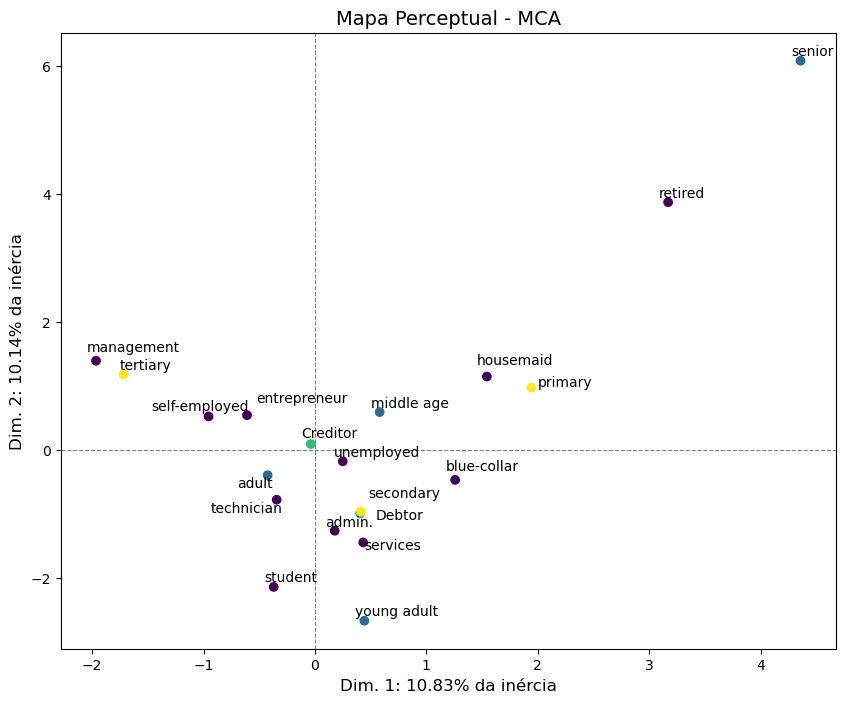

In [191]:
plt.figure(figsize=(10,8))

plt.scatter(chart_df_mca.iloc[:,1], chart_df_mca.iloc[:,2], c = chart_df_mca['Cores'])

texts = [] 
for i, txt in enumerate(chart_df_mca['categoria_id']):
    texts.append(plt.text(chart_df_mca.iloc[i, 1], chart_df_mca.iloc[i, 2], txt, ha='center'))

plt.axhline(y=0, color='grey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='grey', ls='--', linewidth=0.8)
plt.title("Mapa Perceptual - MCA", fontsize=14)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=12)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=12)
adjust_text(texts)

# Clusterização

A clusterização foi feita utilizando um método hierárquico aglomerativo que conseguiu trazer os resultados mais interessantes. Elencamos abaixo:

- Idoso e Aposentado formaram um cluster que é bastante intuitivo. 
- Empresário, Autonômos, cargos de gestão formaram um cluster com ensino terciário, também incluíndo credor. 
- Estudantes, jovens e outras profissões com menor qualificação técnica formaram um cluster com ensino secundário, também incluíndo devedor. 
- Empregada doméstica formou um cluster com ensino primário.

Text(0, 0.5, 'Distância Euclidiana')

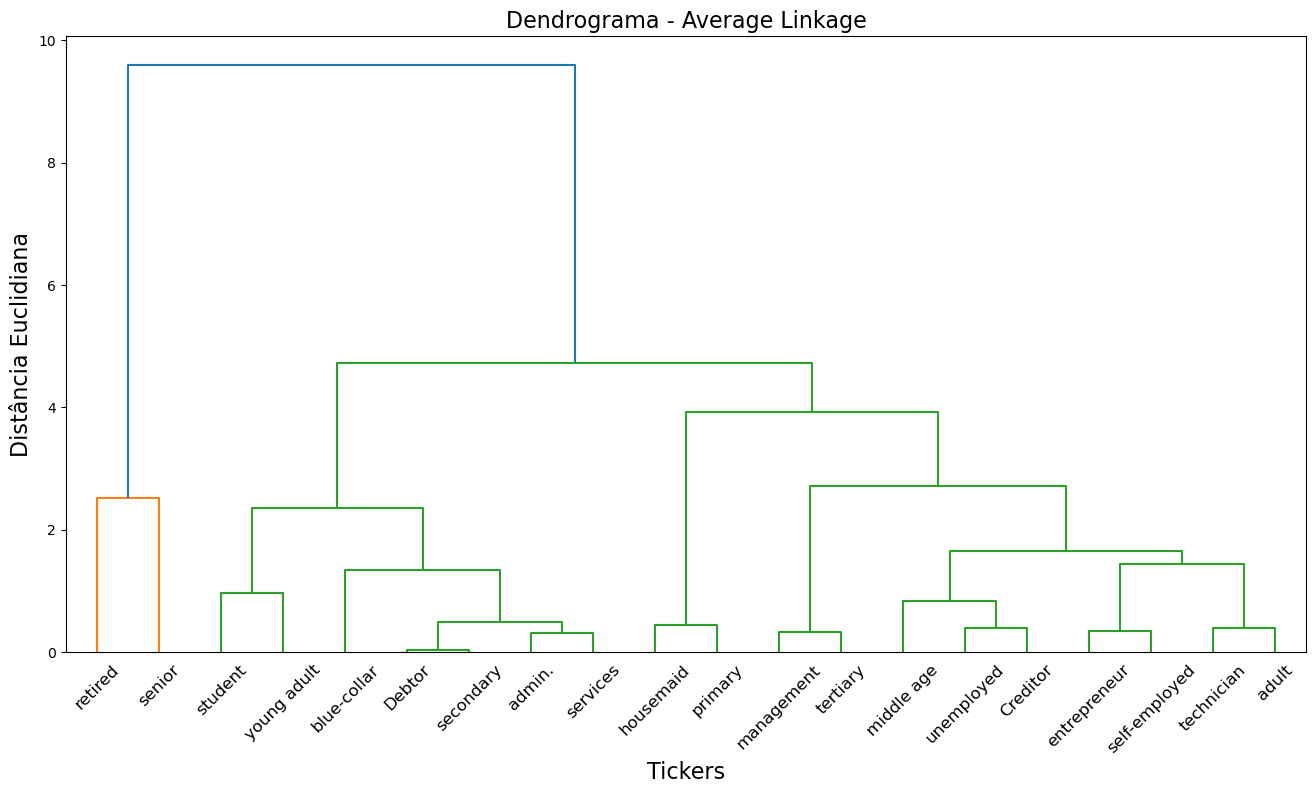

In [225]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(16,8))

h_linkage = sch.linkage(chart_df_mca[['obs_x', 'obs_y']], method = 'complete', metric = 'euclidean')
dendrogram = sch.dendrogram(h_linkage, labels = list(chart_df_mca['categoria_id'].values))

plt.title('Dendrograma - Average Linkage', fontsize=16)
plt.xlabel('Tickers', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Distância Euclidiana', fontsize=16)

In [220]:
from sklearn.cluster import AgglomerativeClustering

cluster_comp = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'complete')
indica_cluster_comp = cluster_comp.fit_predict(chart_df_mca[['obs_x', 'obs_y']])
chart_df_mca['cluster_average'] = indica_cluster_comp
chart_df_mca['cluster_average'] = chart_df_mca['cluster_average'].astype('category')

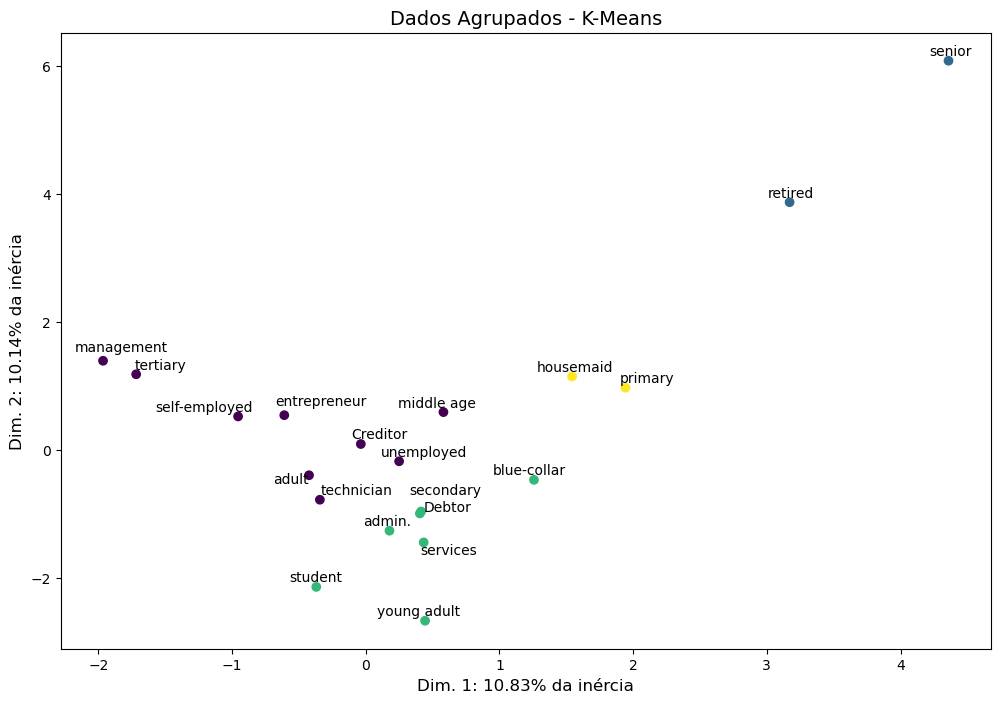

In [221]:
plt.figure(figsize=(12,8))

plt.scatter(chart_df_mca.iloc[:,1], chart_df_mca.iloc[:,2], c = chart_df_mca['cluster_average'])

texts = [] 
for i, txt in enumerate(chart_df_mca['categoria_id']):
    texts.append(plt.text(chart_df_mca.iloc[i, 1], chart_df_mca.iloc[i, 2], txt, ha='center')) 
    
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=12)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=12)
plt.title('Dados Agrupados - K-Means', fontsize=14)
adjust_text(texts)